In [22]:
import numpy as np
import pandas as pd
import math
import datetime
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
data=pd.read_csv("time-series-19-covid-combined.csv")
US_data=data.loc[data.loc[:,'Country/Region']=='US']
US_data.index=[i for i in range (US_data.shape[0])]
df=pd.DataFrame(US_data.Confirmed)
df.head()


,Confirmed
0,1.0
1,1.0
2,2.0
3,2.0
4,5.0


In [23]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df)

In [24]:
look_back = 1 
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
trainX, trainY = create_dataset(data, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))


In [4]:
#建立模型
model = Sequential()
model.add(LSTM(units=256,input_shape=(None,1),return_sequences=True))
model.add(LSTM(units=256))
model.add(Dense(units=1))
#model.add(Activation('linear'))
model.compile(loss='mse',optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1)


Epoch 1/10
72/72 [==============================] - 4s 49ms/step - loss: 0.0291
Epoch 2/10
72/72 [==============================] - 2s 23ms/step - loss: 0.0046
Epoch 3/10
72/72 [==============================] - 2s 24ms/step - loss: 1.0154e-04
Epoch 4/10
72/72 [==============================] - 2s 24ms/step - loss: 8.2673e-05
Epoch 5/10
72/72 [==============================] - 2s 28ms/step - loss: 1.3577e-04
Epoch 6/10
72/72 [==============================] - 2s 33ms/step - loss: 1.2090e-04
Epoch 7/10
72/72 [==============================] - 2s 27ms/step - loss: 1.2599e-04
Epoch 8/10
72/72 [==============================] - 2s 27ms/step - loss: 3.7786e-04
Epoch 9/10
72/72 [==============================] - 2s 31ms/step - loss: 1.1773e-04
Epoch 10/10
72/72 [==============================] - 2s 29ms/step - loss: 5.6674e-05


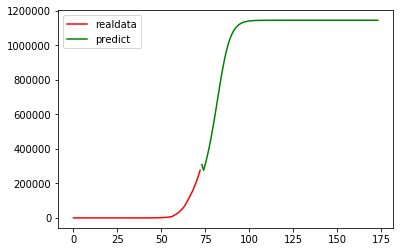

In [28]:
predict = []
time_predict = 100
predict_data = trainX
for i in range(time_predict):
    predict_step=model.predict(predict_data)[-1]
    predict.append(predict_step)
    predict_data = np.append(predict_data[1:,:,:],[[predict_step]],axis=0)
predict_not_scale=scaler.inverse_transform(predict)
result=pd.DataFrame(predict_not_scale)
final_df=pd.DataFrame(np.append(df,result))
plt.plot(final_df.iloc[0:73,],color="red",label='realdata')
plt.plot(final_df.iloc[73::,],color="green",label='predict')
plt.legend()